# Data Mining Final Project
## Classifying Music Decades 1922-2011

**Authors:**

Manthan Gadhia s1032698 || Clara Maine s1032005

In [1]:
# All the base imports required for the project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import scipy,io as sio
import random

from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, classification_report, auc
import itertools

## I. Preprocessing

In [2]:
# Read the dataset into a Pandas Dataframe
music_data = pd.read_csv("YearPredictionMSD.csv")

# Here, we are adding a 'Decade' column to the pandas df based on the track's year of release. 
# This will be the label we are predicting.
music_data['Decade'] = music_data.Year.apply(lambda year : year-(year%10))

# With the purpose of inspecting if the dataset was loaded correctly
music_data.head

<bound method NDFrame.head of         Year  Timbre 1  Timbre 2  Timbre 3  Timbre 4  Timbre 5  Timbre 6  \
0       2001  49.94357  21.47114  73.07750   8.74861 -17.40628 -13.09905   
1       2001  48.73215  18.42930  70.32679  12.94636 -10.32437 -24.83777   
2       2001  50.95714  31.85602  55.81851  13.41693  -6.57898 -18.54940   
3       2001  48.24750  -1.89837  36.29772   2.58776   0.97170 -26.21683   
4       2001  50.97020  42.20998  67.09964   8.46791 -15.85279 -16.81409   
...      ...       ...       ...       ...       ...       ...       ...   
515340  2006  51.28467  45.88068  22.19582  -5.53319  -3.61835 -16.36914   
515341  2006  49.87870  37.93125  18.65987  -3.63581 -27.75665 -18.52988   
515342  2006  45.12852  12.65758 -38.72018   8.80882 -29.29985  -2.28706   
515343  2006  44.16614  32.38368  -3.34971  -2.49165 -19.59278 -18.67098   
515344  2005  51.85726  59.11655  26.39436  -5.46030 -20.69012 -19.95528   

        Timbre 7  Timbre 8  Timbre 9  ...  Covariance 9,1

In [3]:
#Define the data
y = music_data['Decade']
md = music_data.drop(columns=['Year','Decade'])
X = np.array(md)
X.shape

(515345, 90)

In [4]:
# Split the data into training and testing sets using 2/3 holdout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

## II. Studying the dataset

### Moving Average

When the year of an entry is plotted against it's index in the dataframe, we can clearly see that they 
are not chronologically ordered. However, it does appear that the distribution of entries for later decades 
(closer to the 2000s) is quite uniform. For now, we will continue with the assumption that the entries
for earlier decades is also uniform enough.

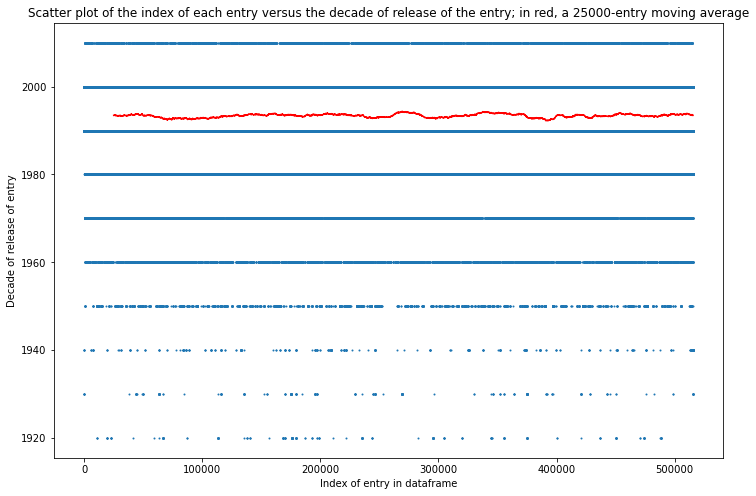

In [35]:
# 25000-entry moving average to see if there are any big fluctuations to check if the data is uniform enough
size = [i for i, year in enumerate(music_data['Decade'])]
dec = music_data['Decade']
window = 25000

moving_avg = dec.rolling(window=window).mean()

fig, ax = plt.subplots(figsize=(12, 8))
ax.scatter(x = size, y = dec, s=1)
plt.plot(size, moving_avg, color='red')
plt.title("Scatter plot of the index of each entry versus the decade of release of the entry; in red, a {}-entry moving average".format(str(window)))
plt.xlabel("Index of entry in dataframe")
plt.ylabel("Decade of release of entry")

plt.show()

### Unbalanced Data
The Histograph below shows that the dataset has a much higher concentration of music from the year 2000 and 1990. In order to acheive 58% Accuracy, all any model has to do is classify the test data into the year 2000. To fix this issue of unbalanced data, we need to undersample the dominant class. This problem is resolved in the tuning of the logistic regression classifer. The parameter `class_weights` is set to `balanced` so the classifer will balance the training data automatically.

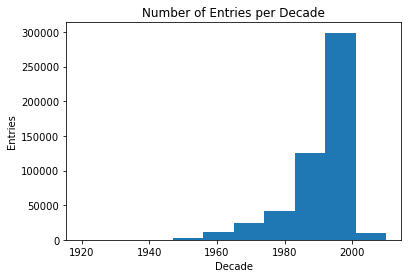

Most Frequent Decade: 2000 accounts for 58.02 percent of data.
2nd Most Frequent Decade: 1990 accounts for 24.2 percent of data.
Together, these two decades account for 82.22 percent of data.


In [19]:
plt.hist(y)
plt.title("Number of Entries per Decade")
plt.xlabel("Decade")
plt.ylabel("Entries")
plt.show()

(values,counts) = np.unique(y,return_counts=True)
majority_dec=np.argmax(counts)
print("Most Frequent Decade: {} accounts for {} percent of data.".format(values[majority_dec], round(counts[majority_dec]/len(y)*100,2)))
print("2nd Most Frequent Decade: {} accounts for {} percent of data.".format(values[7], round(counts[7]/len(y)*100,2)))
print("Together, these two decades account for {} percent of data.".format(round((counts[majority_dec]+counts[7])/len(y)*100,2)))


## III. Algorithm 1: Decision Tree

Strategy: group the data into the decade bins and then build the decision tree. This doesn't allow for extrapolation back to the year of release, but it would probably lead to a more general decision tree, which is ideal.

### Optimise Hyperparameters

In [20]:
# For ease of testing, I am creating a new df which is a random selection of 10% of the rows -- this would result in a dataset of
# size ~50,000 instead of 500,000. 
sample = music_data.sample(frac=0.4)

y_sample = sample['Decade']
y_sample
md_sample = sample.drop(columns=['Year','Decade'])
X_sample = np.array(md_sample)

In [16]:
#define modules
scaler = StandardScaler()
pca = decomposition.PCA()
tree_clf = tree.DecisionTreeClassifier(class_weight='balanced')

#preprocessing pipeline
pipe = Pipeline(steps = [('scaler', scaler), ('tree_clf', tree_clf)])

#define params that we want to optimize for the classifier
max_depth = list(range(5, 36, 5))
min_samples_split = list(range(10, 51, 5))
min_samples_leaf = list(range(1,10))

#create a dictionary to set all the parameters options for different modules
params = dict(tree_clf__max_depth = max_depth, tree_clf__min_samples_split = min_samples_split, 
              tree_clf__min_samples_leaf = min_samples_leaf)

### Use `GridSearch` Module

In [18]:
#Optimize hyperparameters 
tree_clf_GS = GridSearchCV(pipe, params, verbose=4, n_jobs=-1, cv=3)
tree_clf_GS.fit(X_sample, y_sample)

Fitting 3 folds for each of 567 candidates, totalling 1701 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed: 16.2min
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed: 35.7min
[Parallel(n_jobs=-1)]: Done 597 tasks      | elapsed: 68.9min
[Parallel(n_jobs=-1)]: Done 866 tasks      | elapsed: 120.6min
[Parallel(n_jobs=-1)]: Done 1185 tasks      | elapsed: 178.0min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 244.1min
[Parallel(n_jobs=-1)]: Done 1701 out of 1701 | elapsed: 273.2min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('tree_clf',
                                        DecisionTreeClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'tree_clf__max_depth': [5, 10, 15, 20, 25, 30, 35],
                         'tree_clf__min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8,
                                                        9],
                         'tree_clf__min_samples_split': [10, 15, 20, 25, 30, 35,
                                                         40, 45, 50]},
             verbose=4)

In [21]:
print('Best max_depth:', tree_clf_GS.best_estimator_.get_params()['tree_clf__max_depth'])
print('Best min_samples_split:', tree_clf_GS.best_estimator_.get_params()['tree_clf__min_samples_split'])
print('Best min_samples_leaf:', tree_clf_GS.best_estimator_.get_params()['tree_clf__min_samples_leaf'])
print()
print(tree_clf_GS.best_estimator_.get_params()['tree_clf'])

Best max_depth: 35
Best min_samples_split: 10
Best min_samples_leaf: 1

DecisionTreeClassifier(class_weight='balanced', max_depth=35,
                       min_samples_split=10)


### Train the model

After some testing, the decision was made to use the value 5 for the `min_samples_split` attribute because it provides better results, instead of the 10 that the `GridSearch` module outputted.

In [31]:
best_tree_clf = tree.DecisionTreeClassifier(max_depth=35, min_samples_split=5, min_samples_leaf=1, class_weight='balanced') #faster

best_tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=35,
                       min_samples_split=5)

## IV. Algorithm 2: Logistic Regression

### Optimise Hyperparameters
Balance Hyperparameters with GridSearchCV. We specifically do **not** want to optimize the hyperparameters using the training data.

In [25]:
#define modules
scaler = StandardScaler()
pca = decomposition.PCA()
reg_clf = LogisticRegression(solver='lbfgs', class_weight='balanced')

#preprocessing pipeline
pipe = Pipeline(steps = [('scaler', scaler), ('reg_clf', reg_clf)])

#define params that we want to optimize for the classifier
C = np.logspace(-4,4,10)
itr = list(range(100, 600, 75)) 

#create a dictionary to set all the parameters options for different modules
params = dict(reg_clf__C = C, reg_clf__max_iter=itr)

### Use `GridSearch` Module

In [6]:
#Optimize hyperparameters
clf_GS = GridSearchCV(pipe, params, verbose=4, n_jobs=-1, cv=3)
clf_GS.fit(X, y)

Fitting 3 folds for each of 70 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 31.3min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed: 97.9min finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('reg_clf',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'reg_clf__C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'reg_clf__max_iter': [100, 175, 250, 325, 400, 475,
                                               550]},
             verbose=4)

In [7]:
print('Best C:', clf_GS.best_estimator_.get_params()['reg_clf__C'])
print('Best number of iterations:', clf_GS.best_estimator_.get_params()['reg_clf__max_iter'])
print()
print(clf_GS.best_estimator_.get_params()['reg_clf'])

Best C: 166.81005372000558
Best number of iterations: 250

LogisticRegression(C=166.81005372000558, class_weight='balanced', max_iter=250)


### Train the Model

In [36]:
# best_reg_clf = clf_GS.best_estimator_ #only works if clf_GS has been fit
best_reg_clf = LogisticRegression(C=166.81005372000558, class_weight='balanced', max_iter=250) #faster

best_reg_clf.fit(X_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=166.81005372000558, class_weight='balanced', max_iter=250)

## V. Evaluation
### Accuracy, Classification Report, Confusion Matrix, ROC Curves
We begin by defining all the important functions used in making the final classifier evaluation

In [33]:
#Making all the evalulation functions
def binarized_class_data(truth, pred):
    """ This class transforms linear class data to a binary format. 
        It's useful in calculating the multiclass ROC score and curves
        pred = [c, c, b, a] with only 3 total classes fit to the binarizer
        lb.transform(pred) = [[0, 0, 1], [0, 0, 1], [0, 1, 0], [1, 0, 0]]"""
    lb = LabelBinarizer()
    lb.fit(truth)
    return lb.transform(truth), lb.transform(pred)

def multiclass_roc_auc_score(truth, pred, average="macro"):
    """ returns the area under the ROC curve. Acts as a numerical evaluation of a classifier from 0.0-1.0"""
    truth, pred = binarized_class_data(truth, pred)
    return roc_auc_score(truth, pred, average=average)

def show_confusion_matrix(truth, pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """ shows a multi-class confusion matrix graphically, with or without value normalization"""
    cm = confusion_matrix(truth, pred)
    
    # Display confusion matrix colors
    fig = plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Normalize the ratios between 0 and 1 if needed
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # add text
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def compare_multiclass_roc_curves(y_test, y_score, pred, classes, example_index=-1):
    """ plots the ROC curves for each specific class of a classifier, as well as the micro-averaged curve"""
    n_classes = len(classes)
    y_test, _ = binarized_class_data(y_test, pred)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot of an ROC curve for a specific class
    if(example_index!=-1):
        plt.figure()
        plt.plot(fpr[example_index], tpr[example_index], label='ROC curve (area = %0.2f)' % roc_auc[example_index])
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic example: {}'.format(classes[example_index]))
        plt.legend(loc="lower right")
        plt.show()
    
    # Plot ROC curve
    plt.figure(figsize=(10,10))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                       ''.format(classes[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

In [28]:
def full_clf_report(true, pred, classes, y_score):
    """ displays an evaluation report for the performance of a classifier """
    print("Classification Report:\n", classification_report(true, pred, target_names=classes))
    print("AUC score: ", multiclass_roc_auc_score(true, pred))
    show_confusion_matrix(true, pred, classes)
    compare_multiclass_roc_curves(true, y_score, pred, classes) #Optional: example_index

## Decision Tree Evaluation

training accuracy: 0.9497250065888363
testing accuracy: 0.4673946279047888
Classification Report:
               precision    recall  f1-score   support

        1920       0.11      0.14      0.13        69
        1930       0.08      0.14      0.10        76
        1940       0.03      0.05      0.03       120
        1950       0.08      0.13      0.10      1030
        1960       0.10      0.12      0.11      3934
        1970       0.14      0.17      0.15      8107
        1980       0.19      0.23      0.21     13948
        1990       0.31      0.33      0.32     41118
        2000       0.68      0.62      0.65     98541
        2010       0.04      0.06      0.05      3121

    accuracy                           0.47    170064
   macro avg       0.18      0.20      0.18    170064
weighted avg       0.50      0.47      0.48    170064

AUC score:  0.5582815233745488
Confusion matrix, without normalization


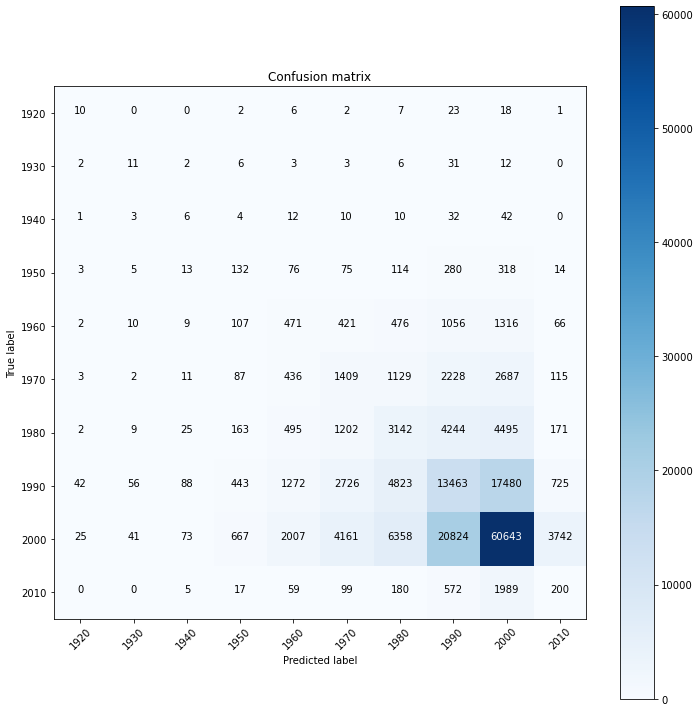

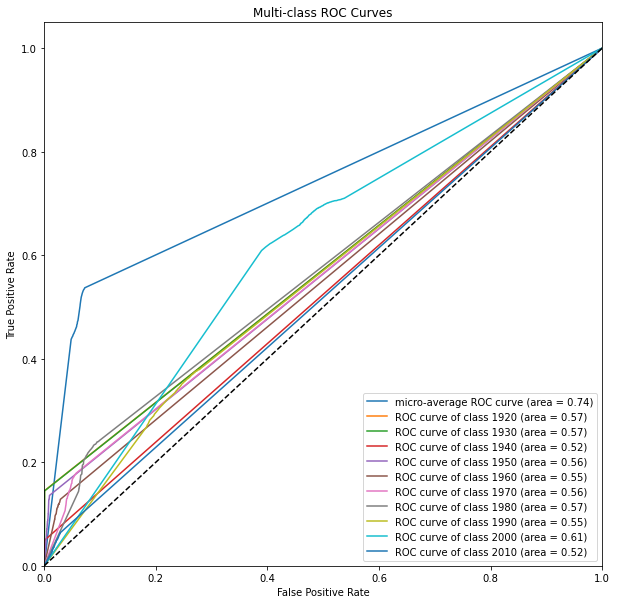

In [34]:
print("training accuracy:", best_tree_clf.score(X_train, y_train))
print("testing accuracy:", best_tree_clf.score(X_test, y_test))

classes = np.array(range(1920,2011,10), dtype='str')
pred = best_tree_clf.predict(X_test)
y_score = best_tree_clf.predict_proba(X_test)
full_clf_report(y_test, pred, classes, y_score)

## Logistic Regression Evaluation

training accuracy: 0.23597591526901276
testing accuracy: 0.23562893969329193
Classification Report:
               precision    recall  f1-score   support

        1920       0.03      0.67      0.05        85
        1930       0.02      0.53      0.04        76
        1940       0.01      0.51      0.03       118
        1950       0.04      0.41      0.07      1031
        1960       0.09      0.30      0.14      3828
        1970       0.17      0.38      0.23      8202
        1980       0.21      0.47      0.29     13950
        1990       0.35      0.19      0.24     41088
        2000       0.75      0.20      0.31     98607
        2010       0.03      0.45      0.06      3079

    accuracy                           0.24    170064
   macro avg       0.17      0.41      0.15    170064
weighted avg       0.55      0.24      0.28    170064

AUC score:  0.6615838599365376
Confusion matrix, without normalization


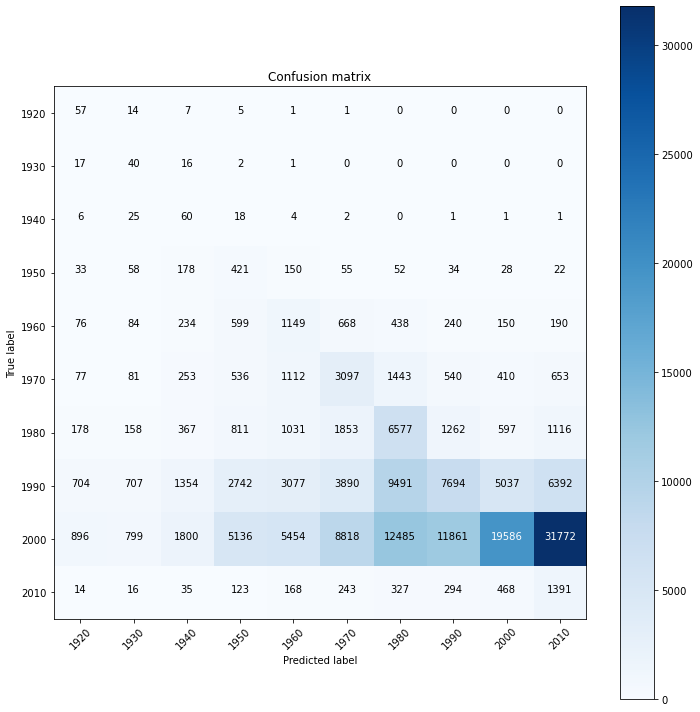

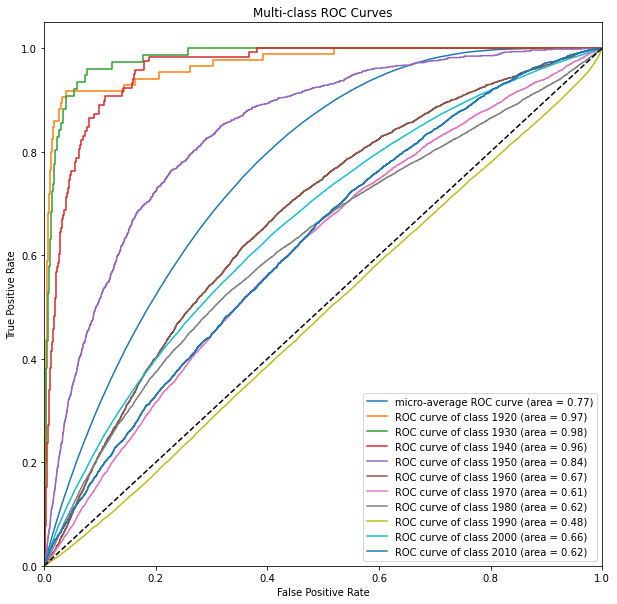

In [37]:
print("training accuracy:", best_reg_clf.score(X_train, y_train))
print("testing accuracy:", best_reg_clf.score(X_test, y_test))

classes = np.array(range(1920,2011,10), dtype='str')
pred = best_reg_clf.predict(X_test)
y_score = best_reg_clf.decision_function(X_test)
full_clf_report(y_test, pred, classes, y_score)

# Applied Examples

In [56]:
def test_song_prediction(reg_clf_pred, decision_tree_pred = None, song_index = 0):
    print("The predicted decade for {} is {} from the decision tree and {} from the logistic regression model.\n The true release decade was {}."\
          .format(song_index, decision_tree_pred[song_index], reg_clf_pred[song_index], y[song_index]))

In [57]:
full_reg_pred = best_reg_clf.predict(X)
full_dt_pred = best_tree_clf.predict(X)
test_song_prediction(full_reg_pred, full_dt_pred, song_index=1)
test_song_prediction(full_reg_pred, full_dt_pred, song_index=1000)

The predicted decade for 1 is 2000 from the decision tree and 1970 from the logistic regression model.
 The true release decade was 2000.
The predicted decade for 1000 is 1990 from the decision tree and 1970 from the logistic regression model.
 The true release decade was 1970.
